In [1]:
%matplotlib inline

# Pairs of Repressors

In this notebook we will evaluate the change in protein expression dynamics and the frequency of developmental errors induced by losing one of two repressors. Each pair of repressors will be drawn combinatorially from a collection of repressors acting to downregulate the target gene's transcription, transcript stability, and protein stability. We will then visualize the resultant change in developmental error frequency under a range of different biosynthesis conditions. The resultant figure panels will be analogous to those labeled Figs. 4G, 7A, and S2H in our manuscript.

### Setting up and running the simulation

First we must import both a `LinearModel` and a `ConditionSimulation` object from the `gram` package.

In [1]:
from gram.models.linear import LinearModel
from gram.simulation.environment import ConditionSimulation

Next we need to define the feedback strengths for each repressor. These are equivalent to $\eta_1$, $\eta_2$, and $\eta_3$ as defined in the manuscript.

In [2]:
eta = (5e-4, 1e-4, 5e-4)

We then perform a nested iteration over this ($\eta_1$, $\eta_2$, $\eta_3$) tuple, constructing a model and performing a `ConditionSimulation` for each pair of repressors. As we are only interested in evaluating the error frequencies, we will discard the simulated dynamics and only keep the `simulation.comparisons` instance for each simulation. Note that with $N=5000$ trajectories per condition, this can take a while. We have provided a completed set of simulations in case you wish to skip this step.

In [ ]:
# iterate over pairs of repressors
comparisons = {}
for i in range(3):
    for j in range(3):

        # define feedback strengths
        permanent = [0, 0, 0]
        permanent[i] = eta[i]
        removed = [0, 0, 0]
        removed[j] = eta[j]

        # define model
        model = LinearModel(g1=0.01, g2=0.001)
        model.add_feedback(*permanent)
        model.add_feedback(*removed, perturbed=True)

        # run simulation and save comparisons
        simulation = ConditionSimulation(model)
        simulation.run(skwargs=dict(N=5000))
        comparisons[(i, j)] = simulation.comparisons

We can quickly save these results for future use using `pickle`.

In [ ]:
import pickle
with open('./comparisons.pkl', 'wb') as file:
    pickle.dump(comparisons, file)

### Generating the figure

We will load the simulation results by unpickling our `comparisons` object. A set of completed simulations have been  provided in the `data/` directory.

In [10]:
import pickle
path = '../data/simulations/repressor_pairs/comparisons.pkl'
with open(path, 'rb') as file:
    comparisons = pickle.load(file)

We will now parse the results into a dictionary containing 3x3 grids for each set of metabolic conditions. Each position in the grid will contain a `threshold_error` - that is the error frequency evaluated for the pair of repressors denoted by that position in the grid.

Note that `gram` uses shorthand notation for each of the metabolic conditions. Specifically:

  * 'normal': normal metabolism
  * 'diabetic': reduced energy metabolism
  * 'minute': reduced protein synthesis
  * 'carbon_limited': reduced RNA/protein synthesis

In [12]:
import numpy as np
matrices = {}
for condition in ('normal', 'diabetic', 'minute', 'carbon_limited'):
    matrix = np.zeros((3, 3), dtype=float)
    for (i,j), comparison in comparisons.items():
        matrix[i, j] = comparison[condition].threshold_error
    matrices[condition] = matrix

# Figures 4G, 7A, and S2H

Finally, we can visualize the grids as heatmaps using `plt.imshow`.

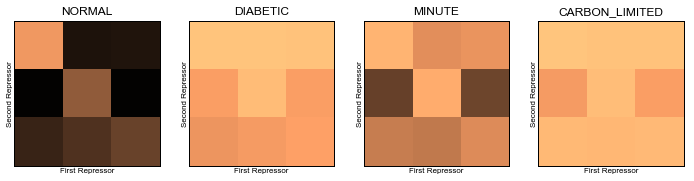

In [13]:
from gram.figures.settings import *
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=4, figsize=(12, 3))
for i, (condition, matrix) in enumerate(matrices.items()):
    axes[i].imshow(matrix.T, cmap=plt.cm.copper_r, vmin=0, vmax=1)
    axes[i].set_title('{:s}'.format(condition.upper()))
    axes[i].set_xlabel('First Repressor')
    axes[i].set_ylabel('Second Repressor')
    axes[i].set_xticks([])
    axes[i].set_yticks([])